# Idle Return Time - Exploratory Data Analysis and Machine Learning Models

### Importing Necessary Libraries

In [9]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

### Reading the Excel File into a Dataframe

In [10]:
FILE  = "ML Verileri.xlsx"
SHEET = "Idle Return Time"
df = pd.read_excel(FILE, sheet_name=SHEET)

In [11]:
df.head()

,FROM,TO,MUSTERI BILGISI,GOODS,TASIMA ARACI,Idle Return Time
0,EGALY,EGEDK,Zresh,Fresh Produce,Demiryolu,8
1,EGALY,EGPSD,AgroFresh,Fresh Produce,Kamyon,5
2,EGALY,ITGOA,Novafresh,Fresh Produce,Kamyon,6
3,EGALY,ITSAL,Orion Foods,Food Products,Demiryolu,7
4,EGALY,ITSPE,AgroFresh,Fresh Produce,Kamyon,5


In [12]:
df.columns = [c.strip() for c in df.columns]
# helpful derived feature: route
df["ROUTE"] = df["FROM"].astype(str) + "->" + df["TO"].astype(str)

print("Rows:", len(df))
display(df.head())

Rows: 500


,FROM,TO,MUSTERI BILGISI,GOODS,TASIMA ARACI,Idle Return Time,ROUTE
0,EGALY,EGEDK,Zresh,Fresh Produce,Demiryolu,8,EGALY->EGEDK
1,EGALY,EGPSD,AgroFresh,Fresh Produce,Kamyon,5,EGALY->EGPSD
2,EGALY,ITGOA,Novafresh,Fresh Produce,Kamyon,6,EGALY->ITGOA
3,EGALY,ITSAL,Orion Foods,Food Products,Demiryolu,7,EGALY->ITSAL
4,EGALY,ITSPE,AgroFresh,Fresh Produce,Kamyon,5,EGALY->ITSPE


## Exploratory Data Analysis

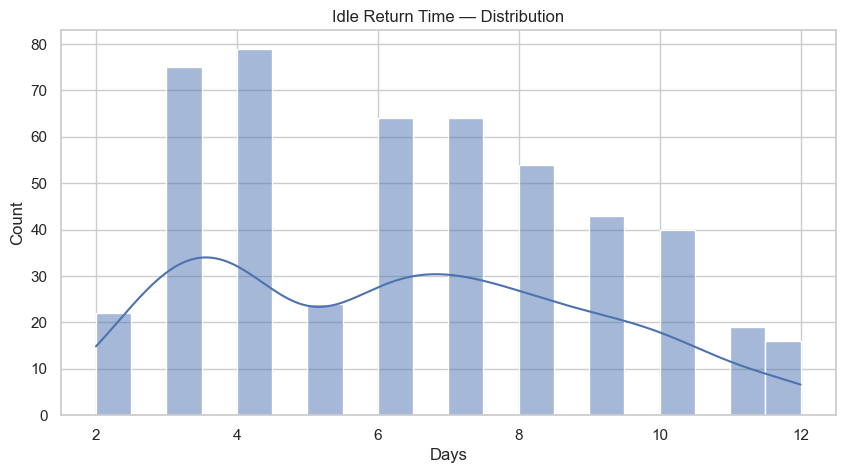

In [14]:
sns.set_theme(style="whitegrid")

# Target distribution
plt.figure(figsize=(10,5))
sns.histplot(df["Idle Return Time"], bins=20, kde=True)
plt.title("Idle Return Time — Distribution")
plt.xlabel("Days")
plt.show()

### Category counts

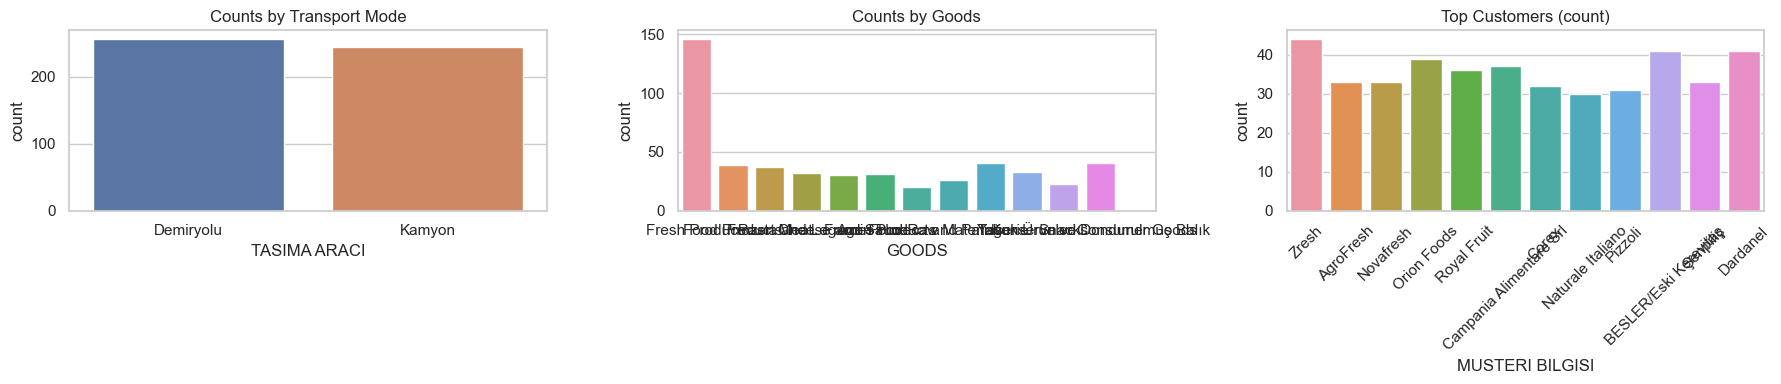

In [15]:

fig, axes = plt.subplots(1,3, figsize=(18,4))
sns.countplot(x="TASIMA ARACI", data=df, ax=axes[0])
axes[0].set_title("Counts by Transport Mode")
sns.countplot(x="GOODS", data=df, ax=axes[1])
axes[1].set_title("Counts by Goods")
top_customers = df["MUSTERI BILGISI"].value_counts().head(12).index
sns.countplot(x="MUSTERI BILGISI", data=df[df["MUSTERI BILGISI"].isin(top_customers)], ax=axes[2])
axes[2].set_title("Top Customers (count)")
axes[2].tick_params(axis='x', rotation=45)
plt.tight_layout(); plt.show()

### Boxplots vs target

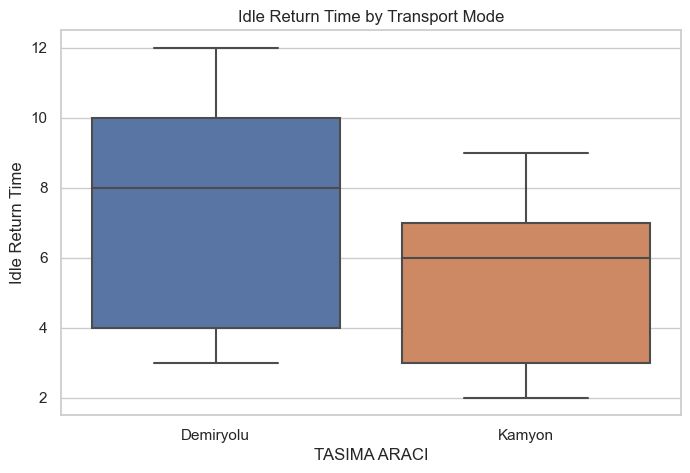

In [16]:
plt.figure(figsize=(8,5))
sns.boxplot(x="TASIMA ARACI", y="Idle Return Time", data=df)
plt.title("Idle Return Time by Transport Mode"); plt.show()

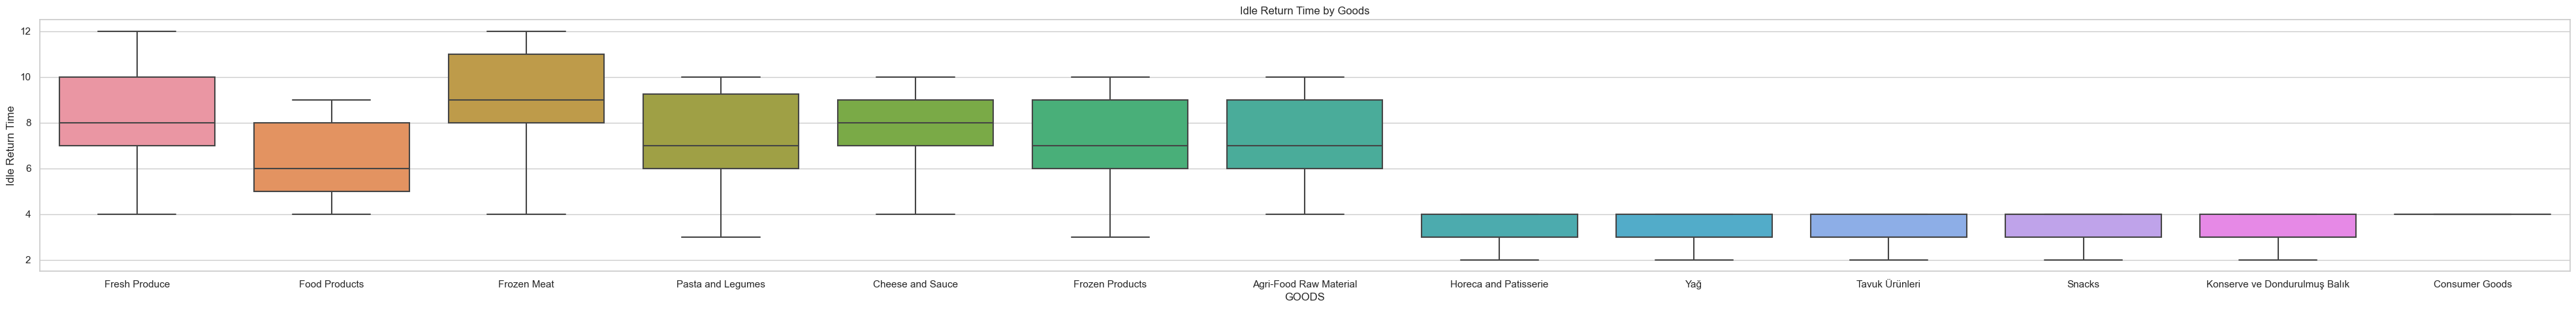

In [18]:
plt.figure(figsize=(50,5))
sns.boxplot(x="GOODS", y="Idle Return Time", data=df)
plt.title("Idle Return Time by Goods"); plt.show()

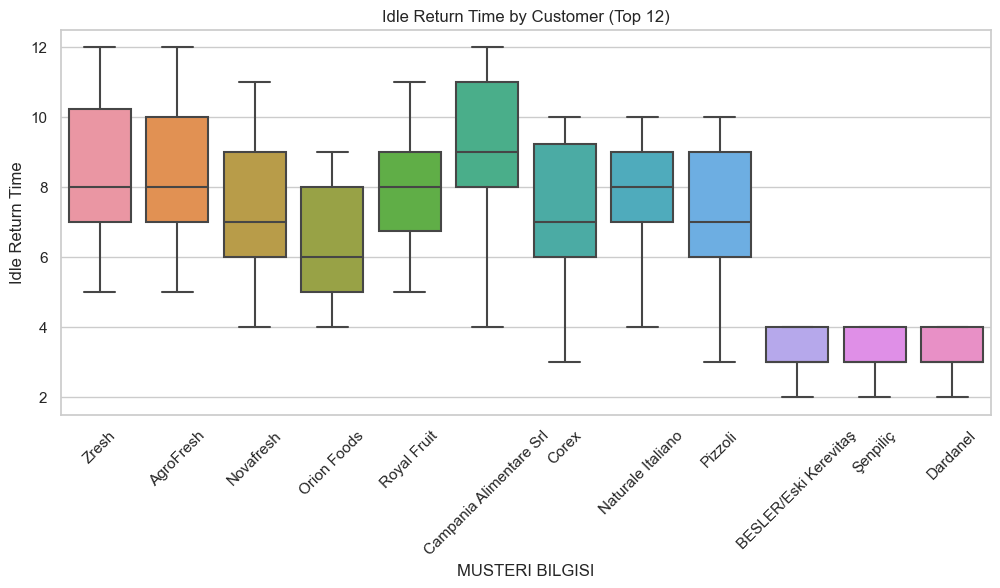

In [19]:
plt.figure(figsize=(12,5))
sns.boxplot(x="MUSTERI BILGISI", y="Idle Return Time",
            data=df[df["MUSTERI BILGISI"].isin(top_customers)])
plt.xticks(rotation=45)
plt.title("Idle Return Time by Customer (Top 12)"); plt.show()


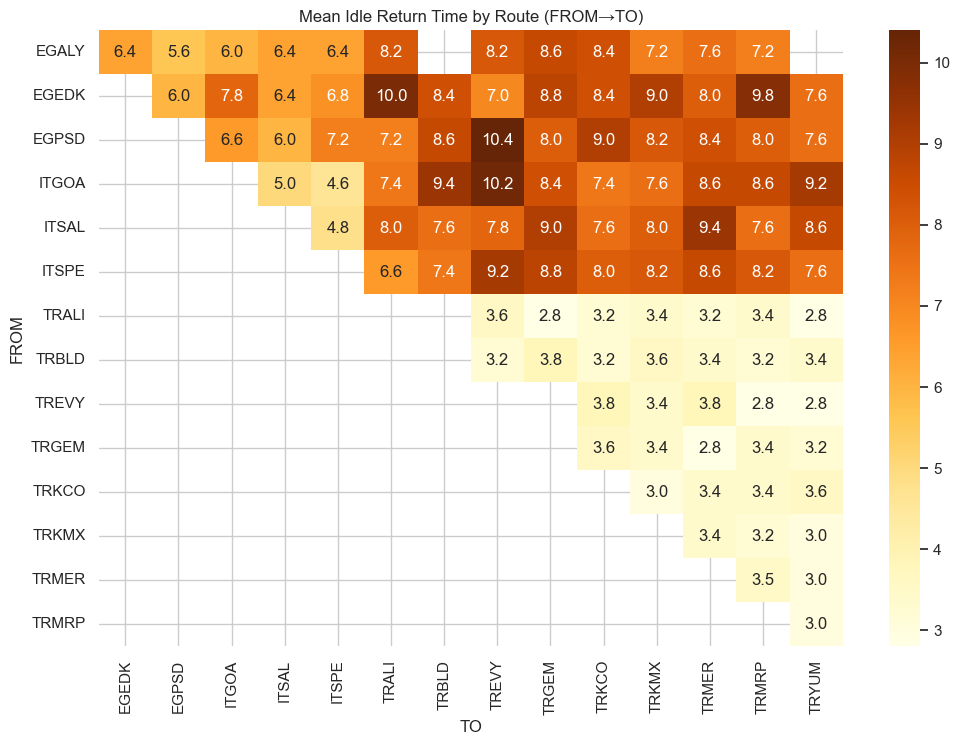

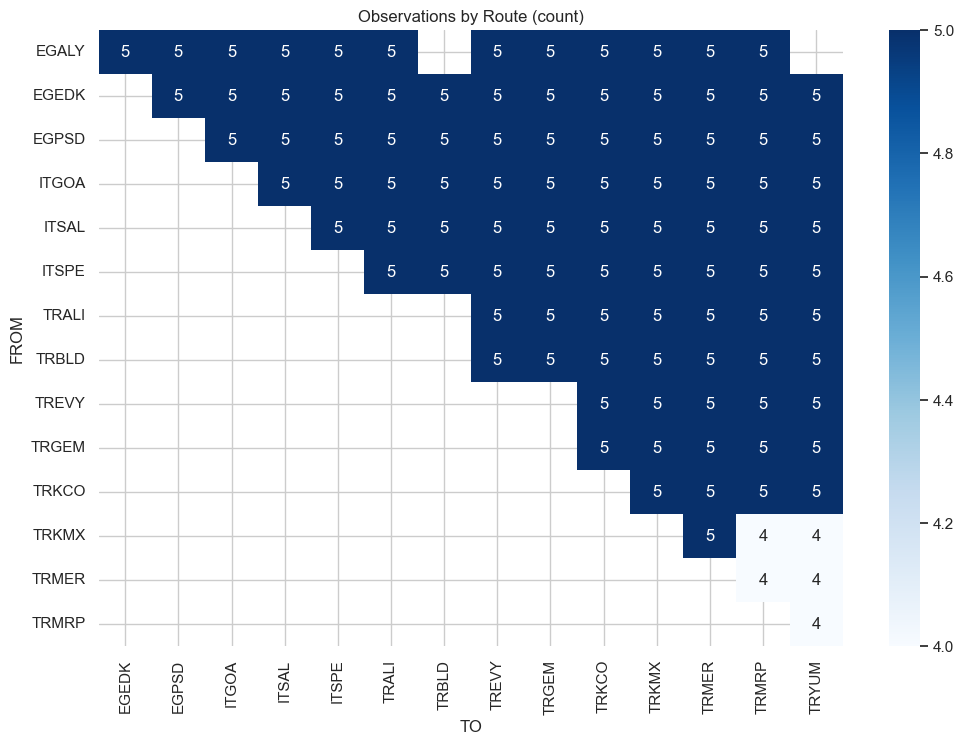

In [20]:

# Route heatmaps (mean and count)
pivot_mean = df.pivot_table(index="FROM", columns="TO",
                            values="Idle Return Time", aggfunc="mean")
plt.figure(figsize=(12,8))
sns.heatmap(pivot_mean, annot=True, fmt=".1f", cmap="YlOrBr")
plt.title("Mean Idle Return Time by Route (FROM→TO)"); plt.show()

pivot_cnt = df.pivot_table(index="FROM", columns="TO",
                           values="Idle Return Time", aggfunc="size")
plt.figure(figsize=(12,8))
sns.heatmap(pivot_cnt, annot=True, fmt=".0f", cmap="Blues")
plt.title("Observations by Route (count)"); plt.show()

### Dividing input variables and output variable Idle Return Time

In [21]:
y = df["Idle Return Time"].astype(float)
X = df[["FROM","TO","ROUTE","MUSTERI BILGISI","GOODS","TASIMA ARACI"]].copy()
#cat_features = list(X.columns)

## Machine Learning Implementation

XGBoost: MAE=0.62, RMSE=0.85, R2=0.903, ±1day%=77.0
RandomForest: MAE=0.63, RMSE=0.83, R2=0.907, ±1day%=80.0


,Model,MAE,RMSE,R2,±1day%
0,XGBoost,0.623924,0.845675,0.903171,77.0
1,RandomForest,0.627874,0.830420,0.906633,80.0


Best model → XGBoost


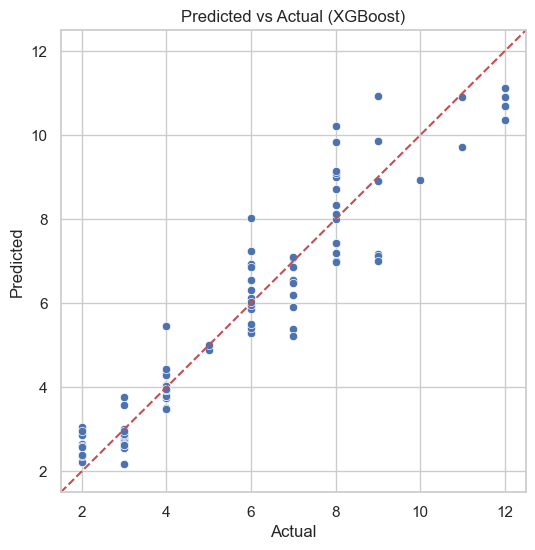

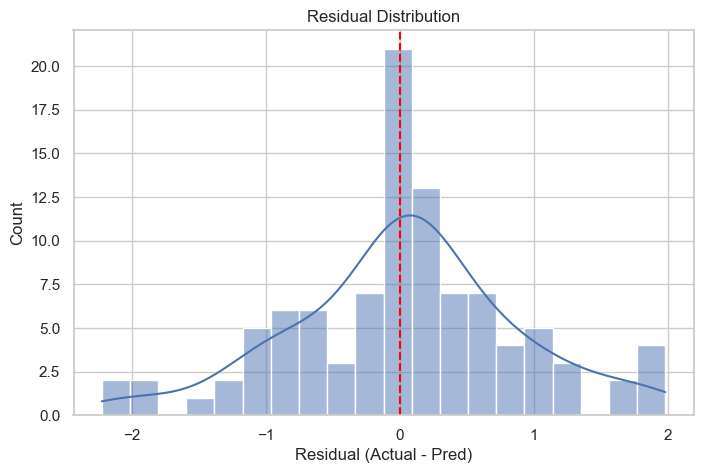

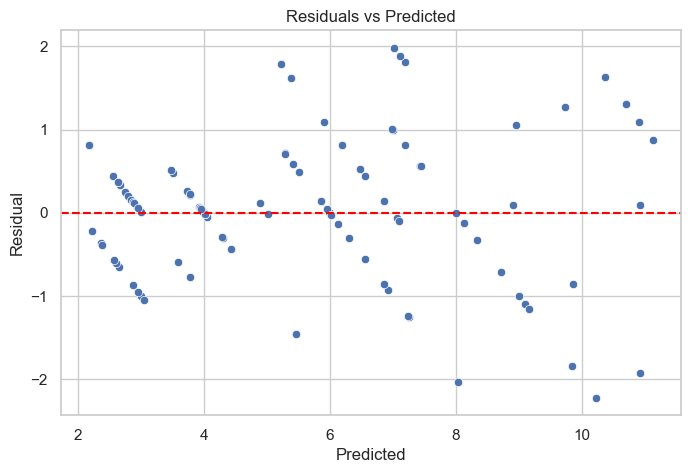

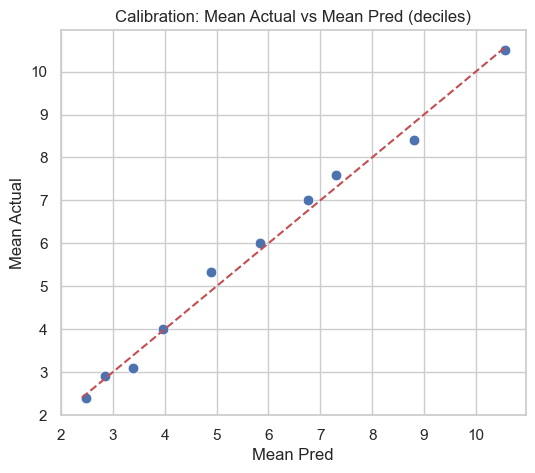

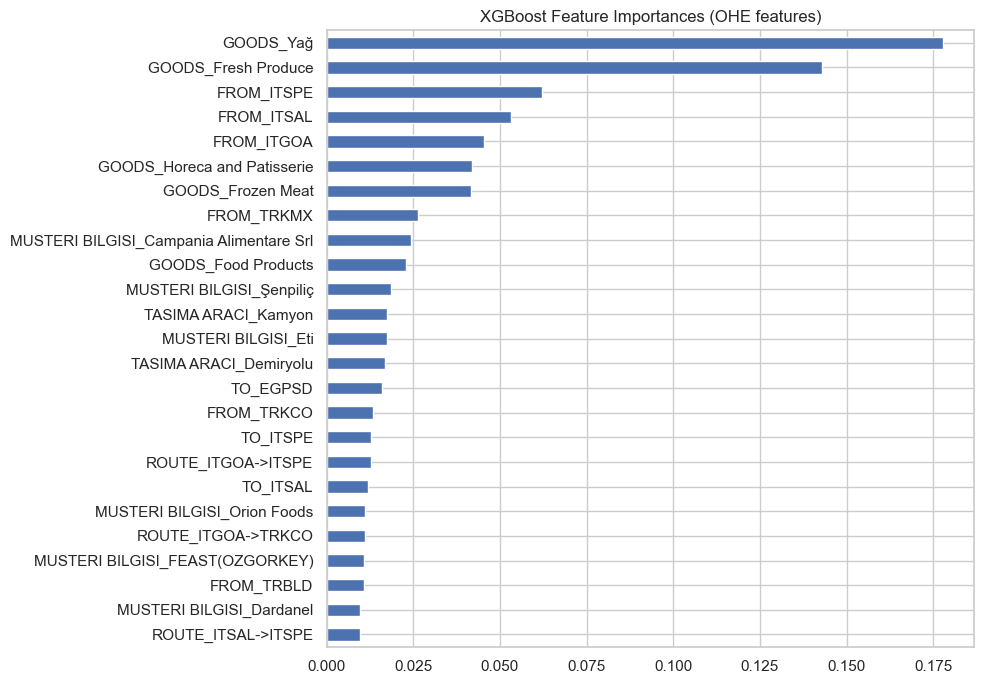

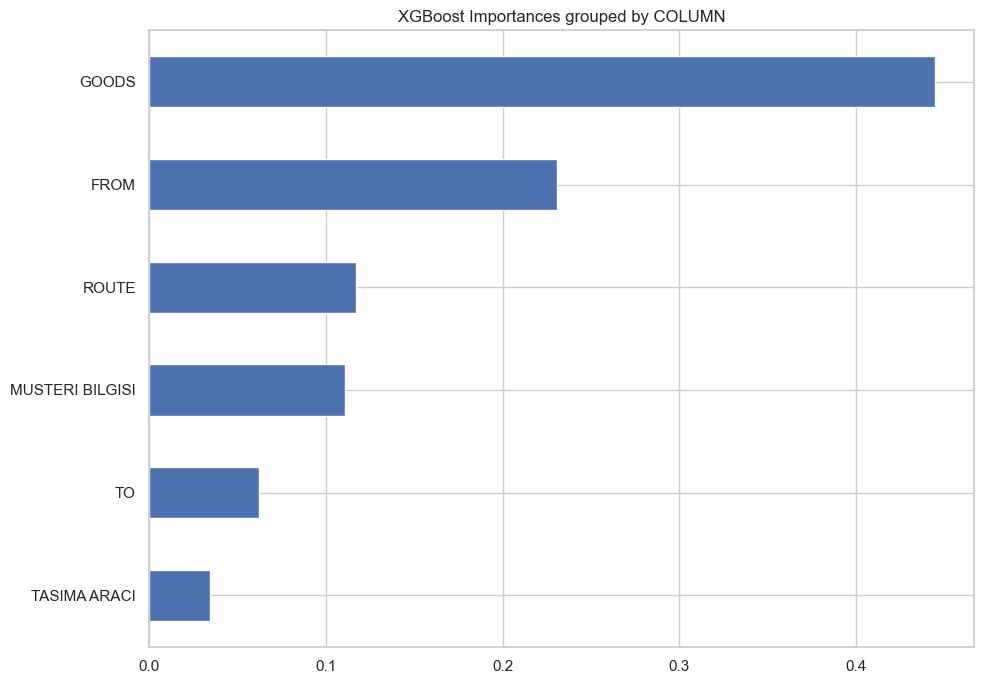

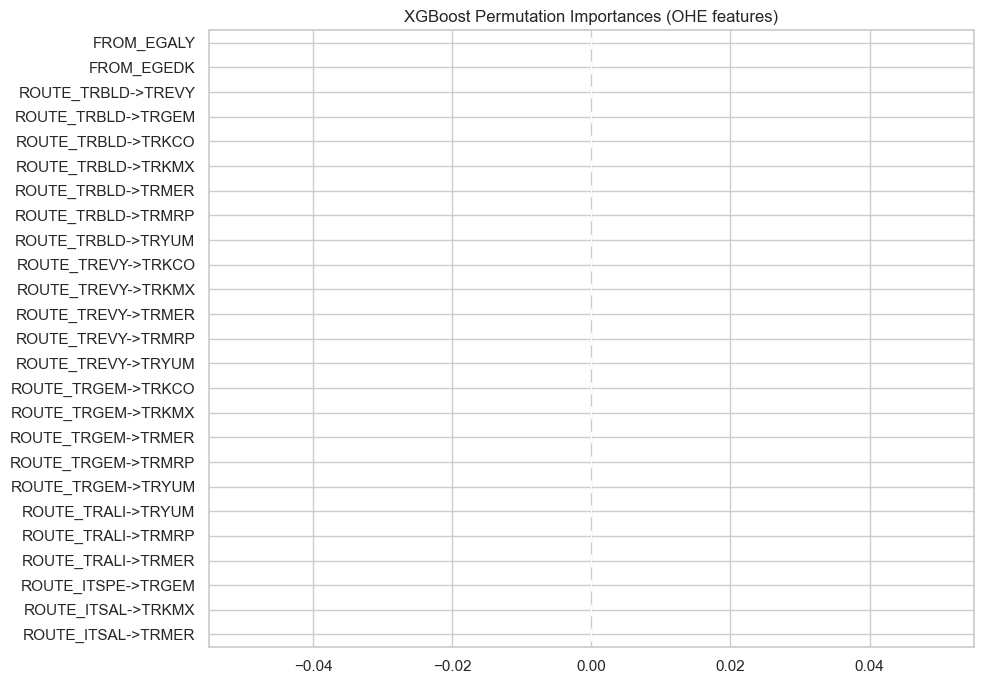

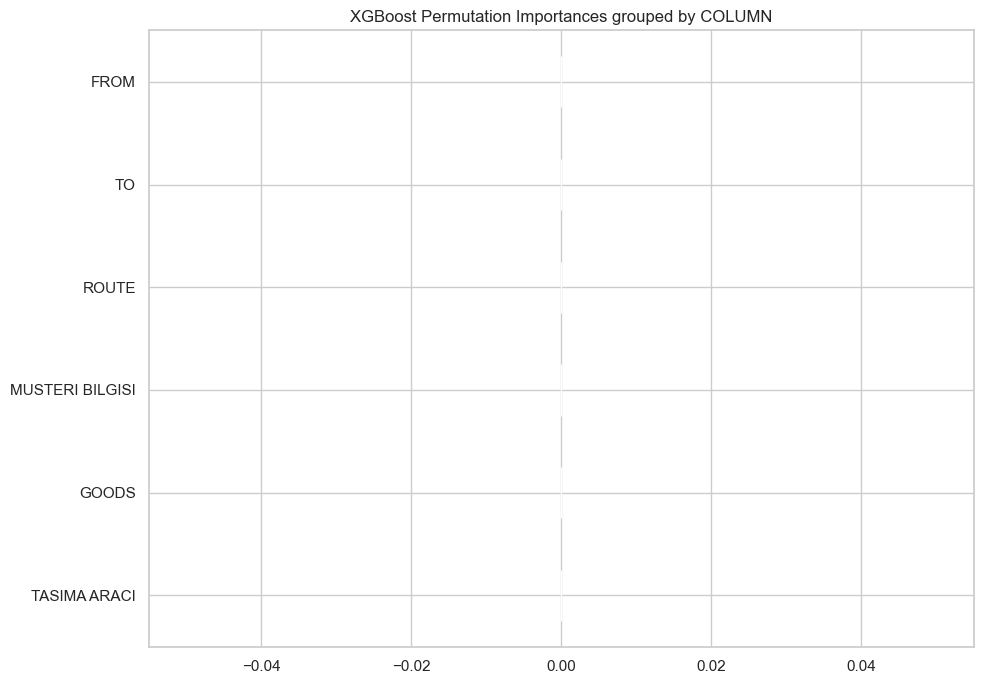

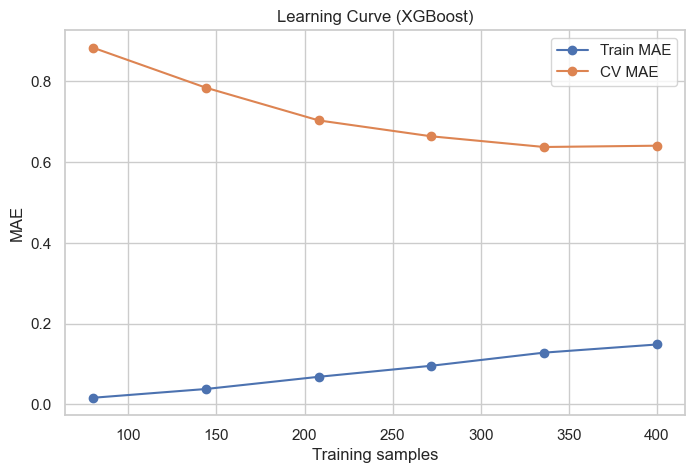


Overall on full data (reference)
MAE: 0.456 | RMSE: 0.684 | R2: 0.936 | ±1day%: 99.4
Saved predictions → /Users/berilenbatan/idle_return_predictions_xgb_rf.xlsx


In [22]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


ohe_xgb = OneHotEncoder(handle_unknown="ignore", sparse=True)
pre_xgb = ColumnTransformer([("cat", ohe_xgb, cat_features)], remainder="drop")

xgb = XGBRegressor(
    n_estimators=900,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.5,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

pipe_xgb = Pipeline([("pre", pre_xgb), ("model", xgb)])
pipe_xgb.fit(X_train, y_train)
pred_xgb = pipe_xgb.predict(X_test)

mae_xgb  = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = math.sqrt(mean_squared_error(y_test, pred_xgb))
r2_xgb   = r2_score(y_test, pred_xgb)
hit1_xgb = (np.abs(y_test - pred_xgb) <= 1).mean()*100
print(f"XGBoost: MAE={mae_xgb:.2f}, RMSE={rmse_xgb:.2f}, R2={r2_xgb:.3f}, ±1day%={hit1_xgb:.1f}")

# -----------------------------
# 4) Model B: RandomForest (with dense OHE)
# -----------------------------
try:
    ohe_rf = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn ≥1.2
except TypeError:
    ohe_rf = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre_rf = ColumnTransformer([("cat", ohe_rf, cat_features)], remainder="drop")

rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

pipe_rf = Pipeline([("pre", pre_rf), ("model", rf)])
pipe_rf.fit(X_train, y_train)
pred_rf = pipe_rf.predict(X_test)

mae_rf  = mean_absolute_error(y_test, pred_rf)
rmse_rf = math.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf   = r2_score(y_test, pred_rf)
hit1_rf = (np.abs(y_test - pred_rf) <= 1).mean()*100
print(f"RandomForest: MAE={mae_rf:.2f}, RMSE={rmse_rf:.2f}, R2={r2_rf:.3f}, ±1day%={hit1_rf:.1f}")

# -----------------------------
# 5) Pick best & diagnostics
# -----------------------------
results = pd.DataFrame([
    {"Model":"XGBoost","MAE":mae_xgb,"RMSE":rmse_xgb,"R2":r2_xgb,"±1day%":hit1_xgb},
    {"Model":"RandomForest","MAE":mae_rf,"RMSE":rmse_rf,"R2":r2_rf,"±1day%":hit1_rf},
]).sort_values("MAE")
display(results)

best_name = results.iloc[0]["Model"]
best_pipe = pipe_xgb if best_name == "XGBoost" else pipe_rf
print(f"Best model → {best_name}")

# Predictions & residuals (index-safe)
y_pred = best_pipe.predict(X_test)
y_true = y_test.reset_index(drop=True)
resid  = y_true - pd.Series(y_pred)

# Pred vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_true, y=y_pred)
lims = [min(y_true.min(), y_pred.min())-0.5, max(y_true.max(), y_pred.max())+0.5]
plt.plot(lims, lims, 'r--')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title(f"Predicted vs Actual ({best_name})")
plt.show()

# Residuals
plt.figure(figsize=(8,5))
sns.histplot(resid, bins=20, kde=True)
plt.axvline(0, ls="--", c="red")
plt.title("Residual Distribution"); plt.xlabel("Residual (Actual - Pred)")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=resid)
plt.axhline(0, ls="--", c="red")
plt.xlabel("Predicted"); plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.show()

# Calibration by deciles (robust bins)
n_bins = max(4, min(10, len(y_true)))
bins = pd.qcut(pd.Series(y_pred), q=n_bins, duplicates="drop")
cal = pd.DataFrame({"pred": pd.Series(y_pred),
                    "act":  y_true,
                    "bin":  bins}).groupby("bin").agg(pred_mean=("pred","mean"),
                                                     act_mean=("act","mean"))
plt.figure(figsize=(6,5))
sns.scatterplot(x="pred_mean", y="act_mean", data=cal, s=60)
low, high = cal.min().min(), cal.max().max()
plt.plot([low, high], [low, high], 'r--')
plt.title("Calibration: Mean Actual vs Mean Pred (deciles)")
plt.xlabel("Mean Pred"); plt.ylabel("Mean Actual")
plt.show()

# -----------------------------
# 6) Feature Importances
# -----------------------------
def plot_importances(series, title, top=25):
    top_s = series.sort_values(ascending=False).head(top)
    plt.figure(figsize=(10,7))
    top_s.plot(kind="barh", title=title)
    plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()

if best_name == "RandomForest":
    ohe_names = best_pipe.named_steps["pre"].named_transformers_["cat"].get_feature_names_out(cat_features)
    fi = pd.Series(best_pipe.named_steps["model"].feature_importances_, index=ohe_names)
    plot_importances(fi, "RandomForest Feature Importances (OHE features)")
    # grouped by original column
    grouped = {}
    for k, v in fi.items():
        root = k.split("_")[0]
        grouped[root] = grouped.get(root, 0.0) + v
    plot_importances(pd.Series(grouped), "RandomForest Importances grouped by COLUMN", top=len(grouped))
else:
    # XGBoost importances
    ohe_names = best_pipe.named_steps["pre"].named_transformers_["cat"].get_feature_names_out(cat_features)
    booster_importance = pd.Series(best_pipe.named_steps["model"].feature_importances_, index=ohe_names)
    plot_importances(booster_importance, "XGBoost Feature Importances (OHE features)")
    grouped = {}
    for k, v in booster_importance.items():
        root = k.split("_")[0]
        grouped[root] = grouped.get(root, 0.0) + v
    plot_importances(pd.Series(grouped), "XGBoost Importances grouped by COLUMN", top=len(grouped))

# Permutation importance (model-agnostic; slower but reliable)
from sklearn.inspection import permutation_importance
Xte_pre = best_pipe.named_steps["pre"].transform(X_test)

# If sparse, convert to dense
if hasattr(Xte_pre, "toarray"):
    Xte_pre = Xte_pre.toarray()

pi = permutation_importance(
    best_pipe.named_steps["model"],
    Xte_pre,
    y_true,
    n_repeats=20,
    random_state=42,
    scoring="neg_mean_absolute_error"
)

pi_series = pd.Series(pi.importances_mean, index=ohe_names)
plot_importances(pi_series, f"{best_name} Permutation Importances (OHE features)")
grouped_pi = {}
for k, v in pi_series.items():
    root = k.split("_")[0]
    grouped_pi[root] = grouped_pi.get(root, 0.0) + v
plot_importances(pd.Series(grouped_pi), f"{best_name} Permutation Importances grouped by COLUMN", top=len(grouped_pi))

# -----------------------------
# 7) Learning curve (best model)
# -----------------------------
train_sizes, train_scores, val_scores = learning_curve(
    best_pipe, X, y, cv=5, scoring="neg_mean_absolute_error",
    train_sizes=np.linspace(0.2, 1.0, 6), shuffle=True, random_state=42
)
train_mae = -train_scores.mean(axis=1)
val_mae   = -val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mae, marker="o", label="Train MAE")
plt.plot(train_sizes, val_mae, marker="o", label="CV MAE")
plt.title(f"Learning Curve ({best_name})")
plt.xlabel("Training samples"); plt.ylabel("MAE")
plt.legend(); plt.show()

# -----------------------------
# 8) Predict ALL rows & export
# -----------------------------
best_pipe.fit(X, y)
pred_all = np.ceil(best_pipe.predict(X)).astype(int)  # integer days if you prefer integers
out = df.copy()
out["PRED_IDLE_RETURN_TIME"] = pred_all
out["ERR"] = out["Idle Return Time"] - out["PRED_IDLE_RETURN_TIME"]
out["ABS_ERR"] = out["ERR"].abs()

print("\nOverall on full data (reference)")
print(f"MAE: {out['ABS_ERR'].mean():.3f} | "
      f"RMSE: {math.sqrt((out['ERR']**2).mean()):.3f} | "
      f"R2: {r2_score(out['Idle Return Time'], out['PRED_IDLE_RETURN_TIME']):.3f} | "
      f"±1day%: {(out['ABS_ERR']<=1).mean()*100:.1f}")

OUT_XLSX = "idle_return_predictions_xgb_rf.xlsx"
out.to_excel(OUT_XLSX, index=False)
print("Saved predictions →", os.path.abspath(OUT_XLSX))
